<a href="https://colab.research.google.com/github/esgantivar/qmc/blob/torch/examples/torch/mps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install qmc if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/esgantivar/qmc.git@torch -q
else:
    import sys
    sys.path.insert(0, '../../')

In [2]:
import time
import torch
from qmc.torch.mps.torchmps import MPS
from torchvision import transforms, datasets

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Miscellaneous initialization
torch.manual_seed(0)
start_time = time.time()

# MPS parameters
bond_dim = 16
adaptive_mode = False
periodic_bc = False

# Training parameters
num_train = 2000
num_test = 1000
batch_size = 100
num_epochs = 20
learn_rate = 1e-4
l2_reg = 0.0

In [4]:
# Initialize the MPS module
mps = MPS(
    input_dim=28 ** 2,
    output_dim=10,
    bond_dim=bond_dim,
    adaptive_mode=adaptive_mode,
    periodic_bc=periodic_bc,
)

In [5]:
# Set our loss function and optimizer
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mps.parameters(), lr=learn_rate, weight_decay=l2_reg)

In [6]:
# Get the training and test sets
transform = transforms.ToTensor()
train_set = datasets.MNIST("./mnist", download=True, transform=transform)
test_set = datasets.MNIST("./mnist", download=True, transform=transform, train=False)

In [7]:
loss_list = []
accuracy_list = []

In [8]:
# Put MNIST data into dataloaders
samplers = {
    "train": torch.utils.data.SubsetRandomSampler(range(num_train)),
    "test": torch.utils.data.SubsetRandomSampler(range(num_test)),
}

In [9]:
loaders = {
    name: torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=samplers[name], drop_last=True
    )
    for (name, dataset) in [("train", train_set), ("test", test_set)]
}

In [10]:
num_batches = {
    name: total_num // batch_size
    for (name, total_num) in [("train", num_train), ("test", num_test)]
}

In [11]:
for epoch_num in range(1, num_epochs + 1):
    running_loss = 0.0
    running_acc = 0.0

    for inputs, labels in loaders["train"]:
        inputs, labels = inputs.view([batch_size, 28 ** 2]), labels.data

        # Call our MPS to get logit scores and predictions
        scores = mps(inputs)
        _, preds = torch.max(scores, 1)

        # Compute the loss and accuracy, add them to the running totals
        loss = loss_fun(scores, labels)
        with torch.no_grad():
            accuracy = torch.sum(preds == labels).item() / batch_size
            running_loss += loss
            running_acc += accuracy

        # Backpropagate and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(running_loss / num_batches['train'])
    accuracy_list.append(running_acc / num_batches['train'])
    print(f"### Epoch {epoch_num} ###")
    print(f"Average loss:           {running_loss / num_batches['train']:.4f}")
    print(f"Average train accuracy: {running_acc / num_batches['train']:.4f}")

    # Evaluate accuracy of MPS classifier on the test set
    with torch.no_grad():
        running_acc = 0.0

        for inputs, labels in loaders["test"]:
            inputs, labels = inputs.view([batch_size, 28 ** 2]), labels.data

            # Call our MPS to get logit scores and predictions
            scores = mps(inputs)
            _, preds = torch.max(scores, 1)
            running_acc += torch.sum(preds == labels).item() / batch_size

### Epoch 1 ###
Average loss:           2.2790
Average train accuracy: 0.1110
### Epoch 2 ###
Average loss:           1.9856
Average train accuracy: 0.2145
### Epoch 3 ###
Average loss:           1.5608
Average train accuracy: 0.4875
### Epoch 4 ###
Average loss:           0.9344
Average train accuracy: 0.7090
### Epoch 5 ###
Average loss:           0.6036
Average train accuracy: 0.8090
### Epoch 6 ###
Average loss:           0.4879
Average train accuracy: 0.8485
### Epoch 7 ###
Average loss:           0.4145
Average train accuracy: 0.8765
### Epoch 8 ###
Average loss:           0.3514
Average train accuracy: 0.8955
### Epoch 9 ###
Average loss:           0.2806
Average train accuracy: 0.9080
### Epoch 10 ###
Average loss:           0.2546
Average train accuracy: 0.9160
### Epoch 11 ###
Average loss:           0.2372
Average train accuracy: 0.9250
### Epoch 12 ###
Average loss:           0.2030
Average train accuracy: 0.9330
### Epoch 13 ###
Average loss:           0.1882
Average train

Text(0, 0.5, 'Accuracy')

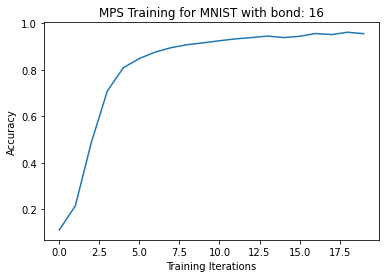

In [15]:
plt.plot(accuracy_list)
plt.title(f'MPS Training for MNIST with bond: {bond_dim}')
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Cross Entropy Loss')

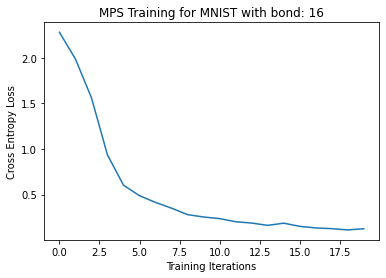

In [14]:
plt.plot(loss_list)
plt.title(f'MPS Training for MNIST with bond: {bond_dim}')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')